In [ ]:
import pandas as pd

# Load your dataset (update 'hourly_time_series.csv' to your actual file path if different)
# Assuming the dataset is stored in a CSV file
df = pd.read_csv('/content/hourly_time_series.csv')

# Create the new column 'Ren' as the sum of 'Wind', 'Solar', and 'Biomass'
df['Ren'] = df['Wind'] + df['Solar'] + df['Biomass']

# Display the first few rows to confirm the new column
print(df.head())


     Biomass         Coal          Gas        Gas-CC       Hydro      Nuclear  \
0  24.422852  7139.291004  1821.296630  11909.157473  116.123442  3764.512096   
1  24.323064  5980.969104  1816.123637  11124.542169  115.884781  3763.160005   
2  24.337510  5500.761559  1848.845507  10148.407981  115.638169  3763.942741   
3  24.337624  5328.113821  1925.732386   9227.963990  115.427869  3764.716900   
4  24.289358  5273.254236  2003.997198   8744.819567  115.445464  3764.507067   

       Other  Solar         Wind                 date          Ren  
0  21.123523    0.0  5615.725887  2012-01-01 01:00:00  5640.148739  
1  21.672131    0.0  5748.293737  2012-01-01 02:00:00  5772.616801  
2  21.571136    0.0  5866.029143  2012-01-01 03:00:00  5890.366653  
3  21.672393    0.0  5989.072335  2012-01-01 04:00:00  6013.409959  
4  21.585433    0.0  5996.661818  2012-01-01 05:00:00  6020.951176  


In [ ]:
# List of columns to keep
columns_to_keep = ['Coal', 'Gas', 'Gas-CC', 'Ren', 'Nuclear','Hydro', 'Other', 'date']

# Create the new DataFrame with only the selected columns
df1 = df[columns_to_keep]

# Display the first few rows of the new DataFrame
print(df1.head())

          Coal          Gas        Gas-CC          Ren      Nuclear  \
0  7139.291004  1821.296630  11909.157473  5640.148739  3764.512096   
1  5980.969104  1816.123637  11124.542169  5772.616801  3763.160005   
2  5500.761559  1848.845507  10148.407981  5890.366653  3763.942741   
3  5328.113821  1925.732386   9227.963990  6013.409959  3764.716900   
4  5273.254236  2003.997198   8744.819567  6020.951176  3764.507067   

        Hydro      Other                 date  
0  116.123442  21.123523  2012-01-01 01:00:00  
1  115.884781  21.672131  2012-01-01 02:00:00  
2  115.638169  21.571136  2012-01-01 03:00:00  
3  115.427869  21.672393  2012-01-01 04:00:00  
4  115.445464  21.585433  2012-01-01 05:00:00  


In [ ]:
# Converting date to a date time object

df1 = df1.copy()  # Create an independent copy
df1['date'] = pd.to_datetime(df1['date'])


In [ ]:
# extracting the temporal features

df1['hour'] = df1['date'].dt.hour
df1['day_of_week'] = df1['date'].dt.dayofweek
df1['day_of_year'] = df1['date'].dt.dayofyear
df1['year'] = df1['date'].dt.year


In [ ]:
import numpy as np

df1['hour_sin'] = np.sin(2 * np.pi * df1['hour'] / 24)
df1['hour_cos'] = np.cos(2 * np.pi * df1['hour'] / 24)
df1['day_of_week_sin'] = np.sin(2 * np.pi * df1['day_of_week'] / 7)
df1['day_of_week_cos'] = np.cos(2 * np.pi * df1['day_of_week'] / 7)
df1['day_of_year_sin'] = np.sin(2 * np.pi * df1['day_of_year'] / 365)
df1['day_of_year_cos'] = np.cos(2 * np.pi * df1['day_of_year'] / 365)


In [ ]:
df1 = df1.drop(columns=['hour', 'day_of_week', 'day_of_year'], axis=1)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Select features to normalize (excluding dummy variables)
features_to_normalize = ['Coal', 'Gas', 'Gas-CC', 'Ren', 'Nuclear', 'Hydro', 'Other', 'year']

# Initialize the scaler
scaler = MinMaxScaler()

# Apply scaling
df1[features_to_normalize] = scaler.fit_transform(df1[features_to_normalize])

In [ ]:
from tensorflow.keras import mixed_precision

# Enable mixed precision training
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.mixed_precision import set_global_policy
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Enable mixed precision for faster computation
set_global_policy('mixed_float16')

# Sliding window function
def create_sliding_windows(features, target, timesteps):
    X, y = [], []
    for i in range(len(features) - timesteps):
        X.append(features[i:i+timesteps])
        y.append(target[i+timesteps])
    return np.array(X), np.array(y)

# Create sliding windows
timesteps = 12  # Adjusted timesteps
features = df1[['Gas', 'Gas-CC', 'Ren', 'Nuclear', 'Hydro', 'Other', 'year',
                'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',
                'day_of_year_sin', 'day_of_year_cos']].values
target = df1['Coal'].values

X, y = create_sliding_windows(features, target, timesteps)

# Adjust df1 to match X and y
df1 = df1.iloc[timesteps:].reset_index(drop=True)

# Define get_fold_indices
def get_fold_indices(start_year, end_year, validation_year, df1):
    train_indices = df1[(df1['date'].dt.year >= start_year) & (df1['date'].dt.year <= end_year)].index
    val_indices = df1[df1['date'].dt.year == validation_year].index
    return train_indices.tolist(), val_indices.tolist()

# Cross-validation setup
fold_ranges = [
    (2012, 2017, 2018),
    (2012, 2018, 2019),
    (2012, 2019, 2020),
    (2012, 2020, 2021),
    (2012, 2021, 2022)
]

# Initialize metrics
fold_metrics = []

for fold, (start_year, end_year, validation_year) in enumerate(fold_ranges):
    print(f"Fold {fold + 1}: Training on {start_year}-{end_year}, Validating on {validation_year}")

    # Get train and validation indices
    train_indices, val_indices = get_fold_indices(start_year, end_year, validation_year, df1)

    # Use pre-scaled X and y
    X_train, y_train = X[train_indices], y[train_indices]
    X_val, y_val = X[val_indices], y[val_indices]

    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")

    # Define model
    model = Sequential([
        LSTM(64, activation='tanh', return_sequences=False, input_shape=(timesteps, X_train.shape[2])),
        Dropout(0.1),  # Adjusted dropout for better generalization
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')  # Adjusted learning rate

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=75, batch_size=32, callbacks=[early_stopping], verbose=1)

    # Validate
    val_predictions = model.predict(X_val)

    # Evaluate in original scale (if applicable)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
    print(f"Validation RMSE for Fold {fold + 1}: {val_rmse}")

    # Append metrics
    fold_metrics.append({
        'fold': fold + 1,
        'val_rmse': val_rmse,
        'history': history
    })


Fold 1: Training on 2012-2017, Validating on 2018
X_train: (52595, 12, 13), y_train: (52595,)
X_val: (8760, 12, 13), y_val: (8760,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/75
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0308 - val_loss: 0.0154
Epoch 2/75
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0169 - val_loss: 0.0162
Epoch 3/75
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0125 - val_loss: 0.0225
Epoch 4/75
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0107 - val_loss: 0.0242
Epoch 5/75
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0097 - val_loss: 0.0286
Epoch 6/75
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0087 - val_loss: 0.0262
Epoch 7/75
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0079 - val_loss: 0.0283
Epoch 8/75
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0069 - val_loss: 0.0379
Epoch 9/75
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0060 - val_loss: 0.0447
Epoch 10/75
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0053 - val_loss: 0.0372
Epoch 11/75
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0047 - val_loss: 0.0387
274/274 ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1918/1918 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.0317 - val_loss: 0.0306
Epoch 2/75
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0161 - val_loss: 0.0281
Epoch 3/75
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0136 - val_loss: 0.0283
Epoch 4/75
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0118 - val_loss: 0.0251
Epoch 5/75
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0103 - val_loss: 0.0198
Epoch 6/75
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0090 - val_loss: 0.0280
Epoch 7/75
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0083 - val_loss: 0.0270
Epoch 8/75
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0075 - val_loss: 0.0210
Epoch 9/75
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0066 - val_loss: 0.0271
Epoch 10/75
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0059 - val_loss: 0.0243
Epoch 11/75
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0054 - val_loss: 0.0197
Epoch 12/75
1918/1918 ━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2192/2192 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0301 - val_loss: 0.0122
Epoch 2/75
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.0159 - val_loss: 0.0075
Epoch 3/75
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0130 - val_loss: 0.0102
Epoch 4/75
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.0108 - val_loss: 0.0075
Epoch 5/75
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.0092 - val_loss: 0.0084
Epoch 6/75
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0077 - val_loss: 0.0091
Epoch 7/75
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0062 - val_loss: 0.0098
Epoch 8/75
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0054 - val_loss: 0.0106
Epoch 9/75
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.0049 - val_loss: 0.0094
Epoch 10/75
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.0046 - val_loss: 0.0095
Epoch 11/75
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0044 - val_loss: 0.0112
Epoch 12/75
2192/2192 ━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/75
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 0.0298 - val_loss: 0.0123
Epoch 2/75
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0136 - val_loss: 0.0142
Epoch 3/75
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0111 - val_loss: 0.0168
Epoch 4/75
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0088 - val_loss: 0.0255
Epoch 5/75
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0072 - val_loss: 0.0193
Epoch 6/75
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0062 - val_loss: 0.0194
Epoch 7/75
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0056 - val_loss: 0.0183
Epoch 8/75
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0051 - val_loss: 0.0151
Epoch 9/75
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0048 - val_loss: 0.0135
Epoch 10/75
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0045 - val_loss: 0.0148
Epoch 11/75
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0042 - val_loss: 0.0151
274/274 ━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/75
2740/2740 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0268 - val_loss: 0.0127
Epoch 2/75
2740/2740 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0127 - val_loss: 0.0057
Epoch 3/75
2740/2740 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0107 - val_loss: 0.0048
Epoch 4/75
2740/2740 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0088 - val_loss: 0.0049
Epoch 5/75
2740/2740 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0065 - val_loss: 0.0050
Epoch 6/75
2740/2740 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0057 - val_loss: 0.0046
Epoch 7/75
2740/2740 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 8/75
2740/2740 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0048 - val_loss: 0.0060
Epoch 9/75
2740/2740 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0045 - val_loss: 0.0058
Epoch 10/75
2740/2740 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0043 - val_loss: 0.0074
Epoch 11/75
2740/2740 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0041 - val_loss: 0.0055
Epoch 12/75
2740/27

In [ ]:
# Define training and testing sets
train_indices = df1[(df1['date'].dt.year >= 2012) & (df1['date'].dt.year <= 2022)].index
test_indices = df1[df1['date'].dt.year == 2023].index

X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]

# Define model with updated configuration
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=False, input_shape=(timesteps, X_train.shape[2])),
    Dropout(0.1),  # Adjusted dropout for consistency with cross-validation
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')  # Adjusted learning rate

# Early stopping with updated patience
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=75, batch_size=32, callbacks=[early_stopping], verbose=1)

# Evaluate on the test set
test_predictions = model.predict(X_test)

# Calculate Test RMSE
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print(f"Test RMSE: {test_rmse}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/75
3014/3014 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.0274 - val_loss: 0.0064
Epoch 2/75
3014/3014 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0132 - val_loss: 0.0061
Epoch 3/75
3014/3014 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0101 - val_loss: 0.0083
Epoch 4/75
3014/3014 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0081 - val_loss: 0.0071
Epoch 5/75
3014/3014 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0070 - val_loss: 0.0080
Epoch 6/75
3014/3014 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0063 - val_loss: 0.0104
Epoch 7/75
3014/3014 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0057 - val_loss: 0.0124
Epoch 8/75
3014/3014 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0051 - val_loss: 0.0122
Epoch 9/75
3014/3014 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0047 - val_loss: 0.0095
Epoch 10/75
3014/3014 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0044 - val_loss: 0.0121
Epoch 11/75
3014/3014 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.0041 - val_loss: 0.0078
Epoch 12/75
3014/30

Plot saved to actual_vs_predicted_jan_2023.png


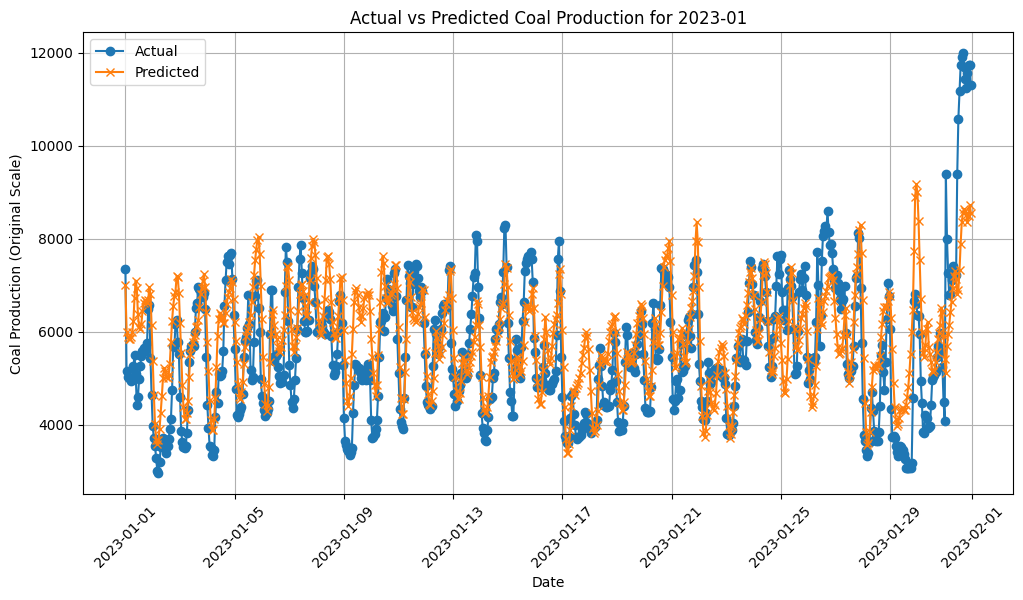

Plot saved to actual_vs_predicted_feb_2023.png


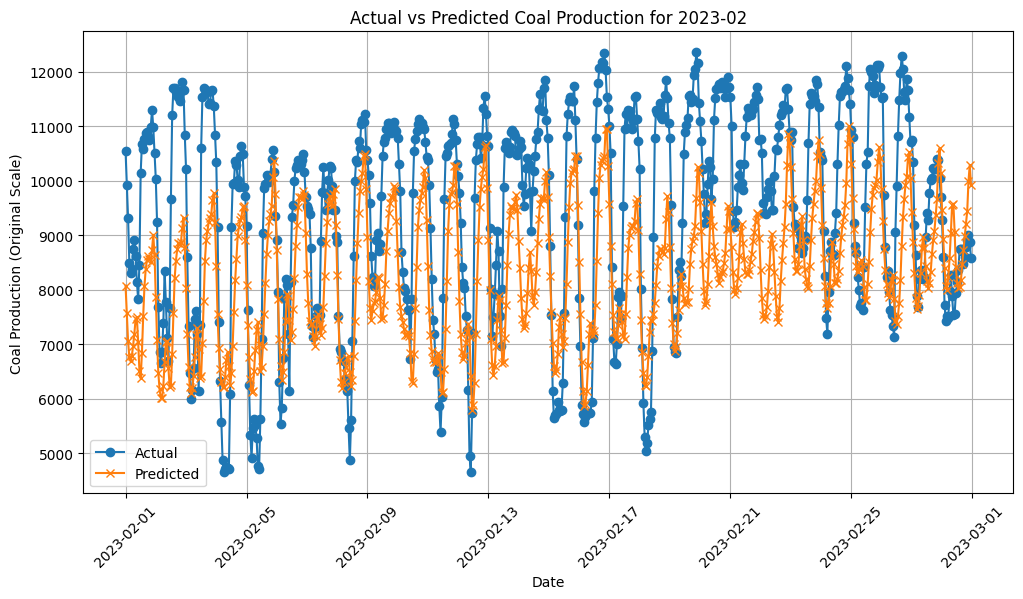

In [ ]:
# CODE TO SAVE THE PLOTTED FIGURES

import matplotlib.pyplot as plt



def plot_actual_vs_predicted(year, month, save_path=None):
    """
    Plots and optionally saves the actual vs predicted values for a specified month and year.

    Args:
        year (int): Year to filter data.
        month (int): Month to filter data.
        save_path (str, optional): Path to save the plot. If None, the plot will not be saved.
    """
    # Filter indices and dates for the specified month and year
    month_indices = df1[(df1['date'].dt.year == year) & (df1['date'].dt.month == month)].index
    month_dates = df1.loc[month_indices, 'date']  # Get actual dates for the x-axis

    # Get scaled predictions and actual values for the specified month
    scaled_actual = y_test[month_indices - test_indices[0]]  # Adjust index to align with y_test
    scaled_predictions = test_predictions[month_indices - test_indices[0]]

    # Invert scaling for predictions and actual values
    actual_values = scaler.inverse_transform(df1.loc[month_indices, features_to_normalize])[:, 0]  # Column 0 corresponds to 'Coal'
    predicted_values = scaler.inverse_transform(
        np.hstack((scaled_predictions, np.zeros((len(scaled_predictions), len(features_to_normalize) - 1))))
    )[:, 0]

    # Plot the actual and predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(month_dates, actual_values, label='Actual', marker='o')
    plt.plot(month_dates, predicted_values, label='Predicted', marker='x')
    plt.xlabel('Date')
    plt.ylabel('Coal Production (Original Scale)')
    plt.title(f'Actual vs Predicted Coal Production for {year}-{month:02}')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.legend()
    plt.grid()

    # Save the plot if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    # Show the plot
    plt.show()

# Example usage:
plot_actual_vs_predicted(2023, 1, save_path='actual_vs_predicted_jan_2023.png')  # Save for January 2023
plot_actual_vs_predicted(2023, 2, save_path='actual_vs_predicted_feb_2023.png')  # Save for February 2023


Loss plot saved to: /content/training_validation_loss_plot.png


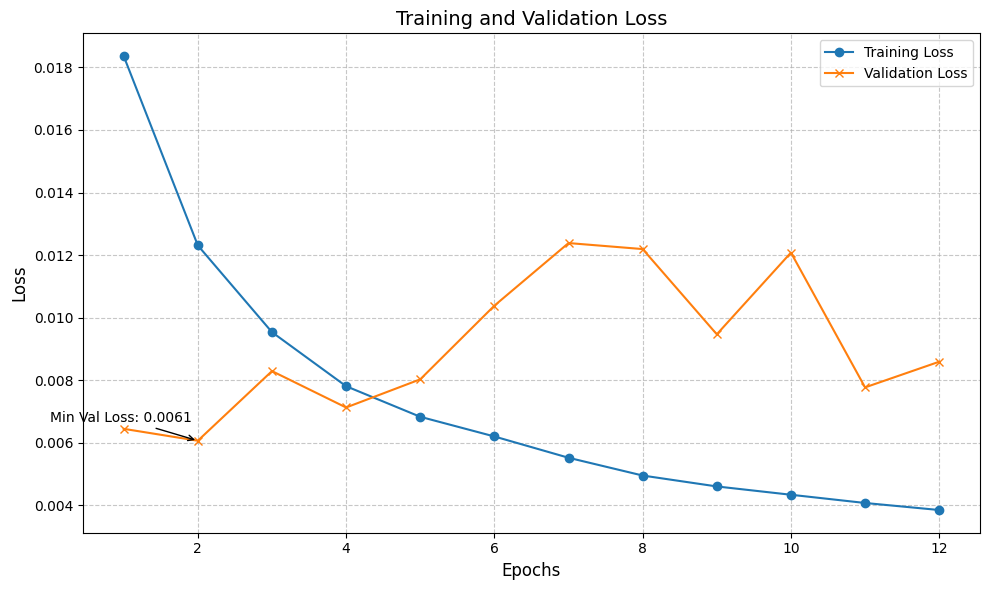

In [ ]:
import matplotlib.pyplot as plt
import os

def plot_and_save_loss(history, save_path='loss_plot.png'):
    """
    Plots the training and validation loss from a Keras model history and saves the plot.

    Args:
        history: Keras model history object.
        save_path: Path where the plot will be saved (default: 'loss_plot.png').
    """
    # Extract loss and validation loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='x')

    # Annotate the lowest validation loss
    min_val_loss_epoch = val_loss.index(min(val_loss)) + 1
    min_val_loss = min(val_loss)
    plt.annotate(
        f"Min Val Loss: {min_val_loss:.4f}",
        xy=(min_val_loss_epoch, min_val_loss),
        xytext=(min_val_loss_epoch - 2, min_val_loss + (0.1 * min_val_loss)),  # Adjust text to stay within bounds
        arrowprops=dict(facecolor='red', arrowstyle="->"),
        fontsize=10
    )

    # Add grid, title, labels, and legend
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.title('Training and Validation Loss', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=10)

    # Ensure the plot fits within the figure boundaries
    plt.tight_layout()

    # Save the plot
    plt.savefig(save_path, dpi=300)
    print(f"Loss plot saved to: {os.path.abspath(save_path)}")

    # Display the plot
    plt.show()

# Usage example:
# Assuming `history` is the result of model.fit()
plot_and_save_loss(history, save_path='training_validation_loss_plot.png')


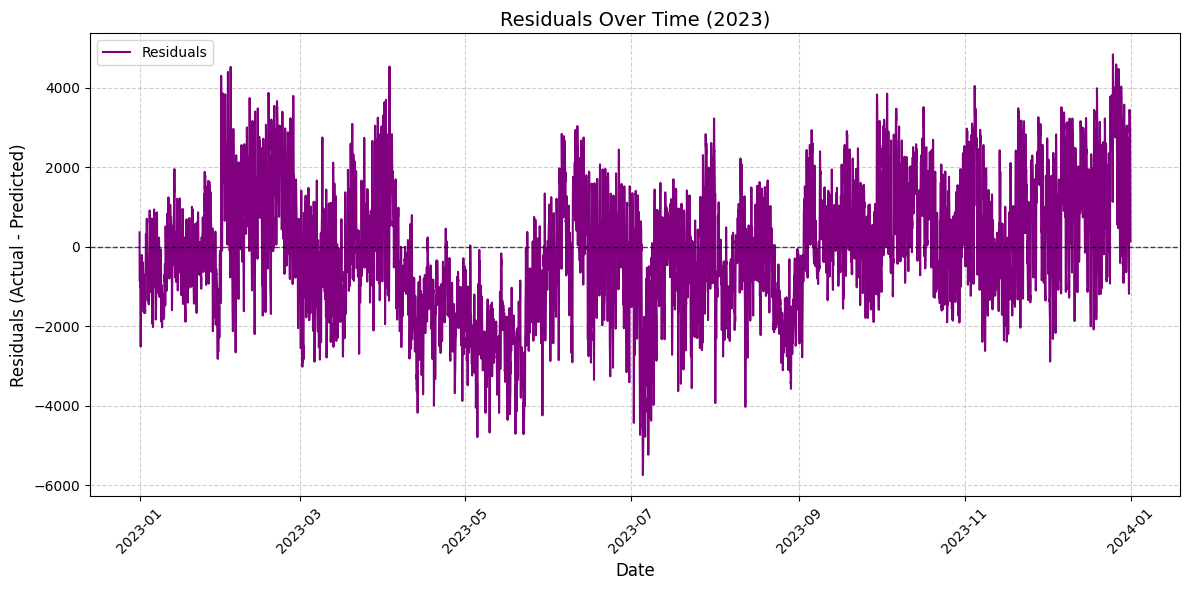

Residuals plot saved as 'residuals_over_time_2023.png'


In [ ]:
# Define actual and predicted values for the entire year 2023
year_indices = df1[df1['date'].dt.year == 2023].index
year_dates = df1.loc[year_indices, 'date']  # Get actual dates for the entire year

# Invert scaling for actual values
actual_values = scaler.inverse_transform(df1.loc[year_indices, features_to_normalize])[:, 0]  # Column 0 corresponds to 'Coal'

# Invert scaling for predicted values
predicted_values = scaler.inverse_transform(
    np.hstack((test_predictions[year_indices - test_indices[0]], np.zeros((len(year_indices), len(features_to_normalize) - 1))))
)[:, 0]

# Function to plot residuals over time
def plot_residuals_over_time(actual_values, predicted_values, dates, save_path='residuals_plot.png'):
    """
    Plots residuals over time and saves the plot to the specified path.

    Args:
        actual_values: Array of actual values in the original scale.
        predicted_values: Array of predicted values in the original scale.
        dates: Array of datetime values corresponding to the actual and predicted values.
        save_path: Path where the plot will be saved (default: 'residuals_plot.png').
    """
    # Create a DataFrame for residuals
residuals_df = pd.DataFrame({
    'date': year_dates,  # Dates for 2023
    'residuals': actual_values - predicted_values  # Residuals calculation
})

# Plot residuals over time
plt.figure(figsize=(12, 6))
plt.plot(residuals_df['date'], residuals_df['residuals'], label="Residuals", color='purple')
plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)  # Add a horizontal line at 0
plt.title("Residuals Over Time (2023)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Residuals (Actual - Predicted)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig('residuals_over_time_2023.png', dpi=300)
plt.show()

print("Residuals plot saved as 'residuals_over_time_2023.png'")



In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import numpy as np


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

# Calculate MAE
mae = mean_absolute_error(actual_values, predicted_values)

# Calculate R² (Coefficient of Determination)
r2 = r2_score(actual_values, predicted_values)

# Calculate Explained Variance Score
explained_variance = explained_variance_score(actual_values, predicted_values)

# Print Metrics
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² (R-Square): {r2:.4f}")
print(f"Explained Variance Score: {explained_variance:.4f}")


RMSE: 1570.2027
MAE: 1259.0428
R² (R-Square): 0.5536
Explained Variance Score: 0.5558
